<a href="https://colab.research.google.com/github/ChirathiSomadasa/Deep_Learning_Assignment/blob/Chandrasoma-M.H.R/Deep_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plant Disease Classification**


## **Somadasa N.M.C.U. - IT22354242**

### Transfer Learning Specialist — MobileNetV2

In [ ]:
# STEP 1: Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Unzip
!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [ ]:
# STEP 2: Fix folder structure if nested

import os
import shutil

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)

# STEP 3: Create smaller dataset for fast demo (200 images/class)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# STEP 4: Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    fast_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    fast_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print(f"Training samples: {train_data.samples}, Validation samples: {val_data.samples}")
print("Classes:", train_data.class_indices)


Found 2362 images belonging to 16 classes.
Found 590 images belonging to 16 classes.
Training samples: 2362, Validation samples: 590
Classes: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14, 'plantvillage': 15}


In [ ]:
# STEP 5: Build MobileNetV2 Model - Stage 1

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load MobileNetV2 with 224x224 input
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base
for layer in base_model.layers:
    layer.trainable = False

# Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for Stage 1
early_stop_stage1 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# STEP 6: TRAIN STAGE 1 — TRAIN HEAD ONLY
print("\n=== STAGE 1: Training Head (Base Frozen) ===")
history_stage1 = model.fit(train_data, validation_data=val_data, epochs=10)

# STEP 7: FINE-TUNING STAGE 2 — UNFREEZE TOP LAYERS + LOW LR
print("\n=== STAGE 2: Fine-Tuning Top Layers ===")

# Unfreeze top 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with LOW learning rate (critical for fine-tuning)
# Stage 2: Unfreeze more layers + lower LR
for layer in base_model.layers[-50:]:  # Unfreeze last 50
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Even lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add ReduceLROnPlateau for better convergence
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
early_stop_stage2 = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train for additional epochs
history_stage2 = model.fit(train_data, validation_data=val_data, epochs=20)

# STEP 8: EVALUATE MODEL — AFTER FULL TRAINING (STAGE 1 + STAGE 2)
print("\n=== FINAL MODEL EVALUATION ===")
final_loss, final_acc = model.evaluate(val_data)
print(f"FINAL Validation Accuracy after Fine-Tuning: {final_acc:.4f} ({final_acc * 100:.2f}%)")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== STAGE 1: Training Head (Base Frozen) ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 79s 841ms/step - accuracy: 0.2990 - loss: 2.1866 - val_accuracy: 0.7153 - val_loss: 0.9858
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 34s 461ms/step - accuracy: 0.6845 - loss: 0.9925 - val_accuracy: 0.7797 - val_loss: 0.7459
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 477ms/step - accuracy: 0.7610 - loss: 0.7529 - val_accuracy: 0.7729 - val_loss: 0.6685
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 488ms/step - accuracy: 0.7990 - loss: 0.6150 - val_accuracy: 0.8593 - val_loss: 0.5349
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 34s 461ms/step - accuracy: 0.8441 - loss: 0.4946 - val_accuracy: 0.8220 - val_loss: 0.5338
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 481ms/step - accuracy: 0.8638 - loss: 0.4576 - val_accuracy: 0.8237 - val_loss: 0.4968
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 36s 484ms/step - accuracy: 0.8497 - loss: 0.4600 - val_accuracy: 0.8559 - val_loss: 0.4663
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 34s 465ms/step - accuracy: 0.8562 - loss: 0.4377 - val_accu

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Path to test image
img_path = "/content/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG"

# Load & preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
pred = model.predict(img_array, verbose=0)
class_index = np.argmax(pred, axis=1)[0]
confidence = np.max(pred)  # Get prediction confidence

# Map prediction to class label
class_labels = {v: k for k, v in train_data.class_indices.items()}
predicted_label = class_labels[class_index]

# Print result
print(f"Predicted Disease: {predicted_label}")
print(f"Confidence: {confidence:.4f} ({confidence * 100:.2f}%)")

Predicted Disease: Pepper__bell___Bacterial_spot
Confidence: 0.9988 (99.88%)


In [ ]:
# Save model

model.save("/content/mobilenetv2_plant_disease_model.keras")
print("\nModel saved to: /content/mobilenetv2_plant_disease_model.keras")



Model saved to: /content/mobilenetv2_plant_disease_model.keras


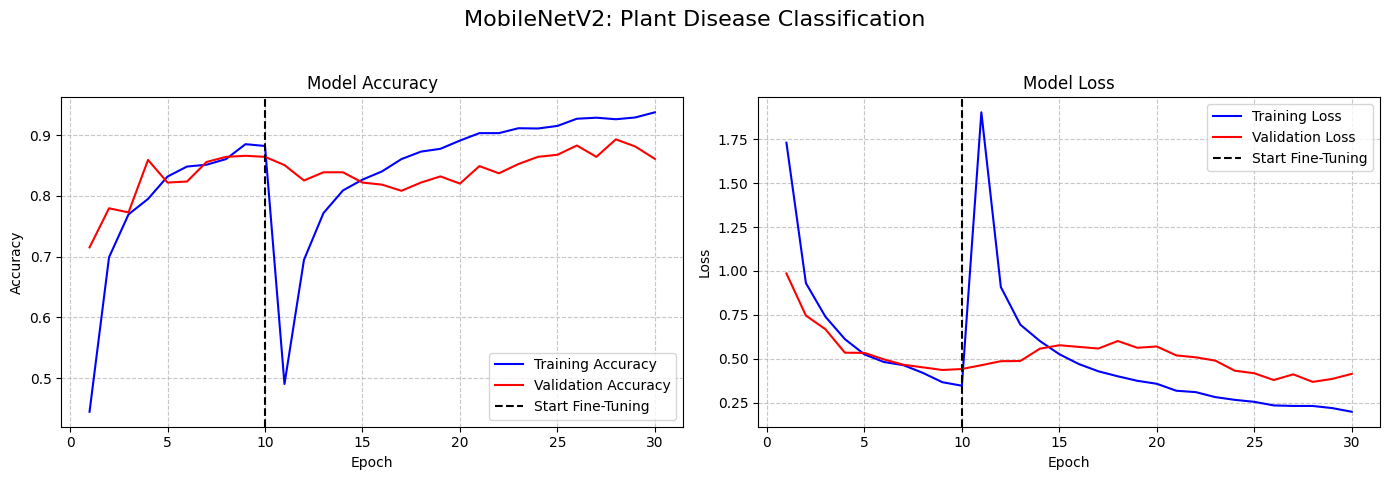

In [ ]:
# VISUALIZE MOBILENETV2 TRAINING PERFORMANCE (Stage 1 + Stage 2)


import matplotlib.pyplot as plt

# Combine histories from both stages
def plot_combined_history(history1, history2, title="MobileNetV2 Training Performance"):
    # Concatenate metrics
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    #  Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    # Mark stage transition
    plt.axvline(x=len(history1.history['accuracy']), color='k', linestyle='--', label='Start Fine-Tuning')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    #  Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.axvline(x=len(history1.history['loss']), color='k', linestyle='--', label='Start Fine-Tuning')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the function with your histories
plot_combined_history(history_stage1, history_stage2, title="MobileNetV2: Plant Disease Classification")

In [ ]:
# Generate classification report
from sklearn.metrics import classification_report
import numpy as np

# Reset and get predictions
val_data.reset()
y_true = val_data.classes
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get unique classes present in validation set
unique_labels = np.unique(y_true)

# Map to class names (only for classes that appear)
class_indices = val_data.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Create target_names in the correct order (0 to max label)
max_label = max(unique_labels)
target_names_filtered = [idx_to_class[i] for i in range(max_label + 1) if i in unique_labels]

# Generate report
report = classification_report(
    y_true,
    y_pred_classes,
    labels=unique_labels,
    target_names=target_names_filtered,
    zero_division=0
)

print(report)

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 586ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.06      0.05      0.05        40
                     Pepper__bell___healthy       0.07      0.07      0.07        40
                      Potato___Early_blight       0.03      0.03      0.03        40
                       Potato___Late_blight       0.07      0.07      0.07        40
                           Potato___healthy       0.06      0.07      0.06        30
                      Tomato_Bacterial_spot       0.09      0.07      0.08        40
                        Tomato_Early_blight       0.12      0.07      0.09        40
                         Tomato_Late_blight       0.03      0.03      0.03        40
                           Tomato_Leaf_Mold       0.02      0.03      0.02        40
                  Tomato_Septoria_leaf_spot       0.08      0.10      0.09        40
Tomato_Spider_mites_Tw

In [ ]:

# Get a sample batch from validation data
val_data.reset()
sample_batch, _ = next(val_data)
print(f"Sample batch shape: {sample_batch.shape}")
# Parameters
print(f"Parameters: {model.count_params():,}")

# Inference time (as shown earlier)
import time
start = time.time()
_ = model.predict(sample_batch, verbose=0)
inference_time = (time.time() - start) / len(sample_batch) * 1000  # ms per image

Sample batch shape: (32, 224, 224, 3)
Parameters: 2,424,016


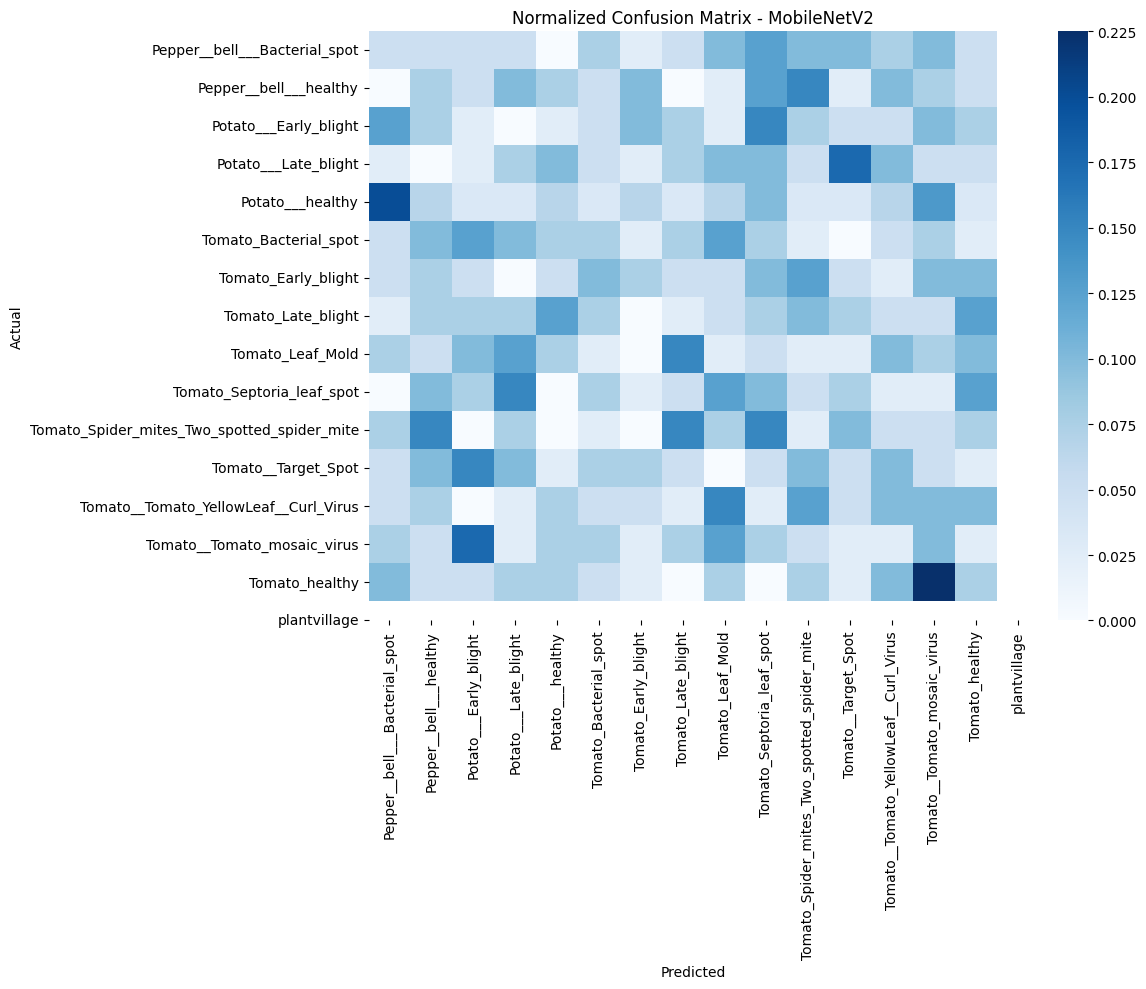

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=False,
    cmap='Blues',
    xticklabels=val_data.class_indices.keys(),
    yticklabels=val_data.class_indices.keys()
)
plt.title("Normalized Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##**Balasooriya B.M.P.U.  -  IT22927248**

### Transfer Leaning Specialist - Custom CNN

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [ ]:
# Fix folder structure if nested

import os
import shutil

In [ ]:
# Check if inner folder exists

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)

In [ ]:
# Create smaller dataset for fast demo (optional)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200  # reduce per class for fast execution

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# Use the fast demo directory for training
data_dir = fast_dir

# Remove any empty directories
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        if len(os.listdir(class_path)) == 0:  # If folder is empty
            os.rmdir(class_path)
            print(f"Removed empty directory: {class_name}")


Removed empty directory: plantvillage


In [ ]:
# Create datasets using the modern approach
import tensorflow as tf

img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)


Found 2952 files belonging to 15 classes.
Using 2362 files for training.
Found 2952 files belonging to 15 classes.
Using 590 files for validation.


In [ ]:
# Apply data augmentation to training dataset

import tensorflow as tf

def augment_images(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.1)
    return image, label

# Apply augmentation only to training data
train_ds = train_ds.map(augment_images)
# Normalize both datasets
train_ds = train_ds.map(lambda x, y: (x/255.0, y))
val_ds = val_ds.map(lambda x, y: (x/255.0, y))

# Optimize performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Training samples: {len(train_ds) * batch_size}")
print(f"Validation samples: {len(val_ds) * batch_size}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")


Training samples: 2368
Validation samples: 608
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# Design the custom CNN architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Create the model
model = Sequential([
    # Input layer
    Input(shape=(128, 128, 3)),

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Fourth convolutional block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - accuracy: 0.2407 - loss: 2.8605 - val_accuracy: 0.0593 - val_loss: 12.7952 - learning_rate: 0.0010
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4872 - loss: 1.6628 - val_accuracy: 0.0593 - val_loss: 18.0152 - learning_rate: 0.0010
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5769 - loss: 1.3567 - val_accuracy: 0.0797 - val_loss: 14.7382 - learning_rate: 0.0010
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6316 - loss: 1.1740 - val_accuracy: 0.0746 - val_loss: 11.5286 - learning_rate: 0.0010
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6779 - loss: 0.9941 - val_accuracy: 0.1051 - val_loss: 12.1935 - learning_rate: 0.0010
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7234 - loss: 0.8417 - val_accuracy: 0.1237 - val_loss: 10.7587 - learning_rate: 0.0010
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7488 - loss: 0.7424 -

In [ ]:
# Evaluate the model

test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8372 - loss: 0.7001
Validation Accuracy: 84.41%


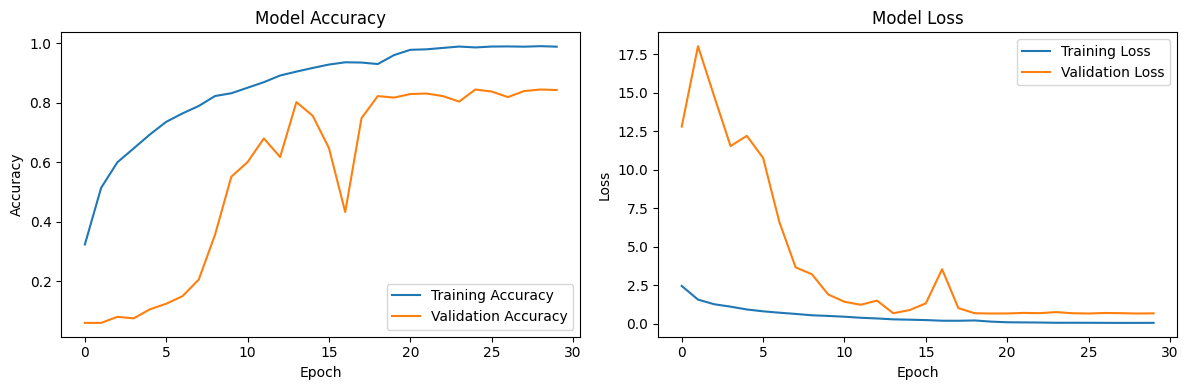

In [ ]:
# Plot training history

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Predictions + classification report

import numpy as np
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.85      0.80      0.82        41
                     Pepper__bell___healthy       0.95      0.90      0.92        39
                      Potato___Early_blight       0.88      0.88      0.88        43
                       Potato___Late_blight       0.66      0.92      0.77        38
                           Potato___healthy       0.97      0.89      0.93        35
                      Tomato_Bacterial_spot       0.62      0.97      0.75        33
                        Tomato_Early_blight       0.76      0.58      0.66        38
                         Tomato_Late_blight       0.84      0.68      0.75        47
                           Tomato_Leaf_Mold       0.85      0.85      0.85        33
                  Tomato_Septoria_leaf_spot       0.89      0.69      0.78        36
Tomato_Spider_mites_Two_spotted_spider_mite       0.76      0.97

In [ ]:
# Model save:

model.save('custom_cnn_plant_disease.keras')
print("Model saved as 'custom_cnn_plant_disease.keras'")

Model saved as 'custom_cnn_plant_disease.keras'


In [ ]:
# Function to predict on new images

def predict_disease(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    return class_names[predicted_class], confidence

In [ ]:
# Test the prediction function with a sample image_1

sample_image_path = "/content/PlantVillage/Tomato_Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG"

predicted_class, confidence = predict_disease(sample_image_path)
print(f"Predicted Disease: {predicted_class} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
Predicted Disease: Tomato_Bacterial_spot with confidence: 1.00


In [ ]:
# Test the prediction function with a sample image_2

sample_image_path = "/content/PlantVillage/Tomato__Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG"

predicted_class, confidence = predict_disease(sample_image_path)
print(f"Predicted Disease: {predicted_class} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Disease: Tomato__Tomato_mosaic_virus with confidence: 0.99


In [ ]:
import time

print(f"Parameters: {model.count_params():,}")

# Get a sample batch from validation data for inference time measurement
sample_batch = None
sample_labels = None
for batch in val_ds.take(1):
    sample_batch, sample_labels = batch
print(f"Sample batch shape: {sample_batch.shape}")

# Measure inference time
start = time.time()
_ = model.predict(sample_batch, verbose=0)
inference_time = (time.time() - start) / len(sample_batch) * 1000  # ms per image
print(f"Inference time per image: {inference_time:.2f} ms")

Parameters: 5,247,695
Sample batch shape: (32, 128, 128, 3)
Inference time per image: 8.74 ms


## **Chandrasoma M.H.R - IT22347412**

### Smart Plant Disease Classifier - EfficientNetB0

In [1]:
# STEP 1: Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [3]:
#Fix folder structure if nested

import os, shutil

In [4]:
# Check if inner folder exists

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)
print("Folder structure fixed!")

Folder structure fixed!


In [5]:
# STEP 3: Create smaller dataset for fast demo (optional)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 500  # limit per class for faster runs

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# Remove empty dirs if any
for class_name in os.listdir(fast_dir):
    class_path = os.path.join(fast_dir, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        os.rmdir(class_path)
        print(f"Removed empty directory: {class_name}")

print("Fast demo dataset created at:", fast_dir)

# Use fast dataset
data_dir = fast_dir

Removed empty directory: plantvillage
Fast demo dataset created at: /content/PlantVillage_FastDemo


In [7]:
# STEP 4: Data Preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"Number of classes detected: {NUM_CLASSES}")

Found 5621 images belonging to 15 classes.
Found 1404 images belonging to 15 classes.
Number of classes detected: 15


In [8]:
# STEP 5: Model Development (EfficientNetB0 + Custom Head)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # freeze for Phase 1

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output, name="smart_plant_disease_classifier")

print("Model Summary:")
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model Summary:


Model: "smart_plant_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 130s 581ms/step - accuracy: 0.0951 - loss: 2.7479 - val_accuracy: 0.3483 - val_loss: 2.3067
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 91s 396ms/step - accuracy: 0.2931 - loss: 2.2927 - val_accuracy: 0.5242 - val_loss: 1.9569
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 70s 394ms/step - accuracy: 0.4654 - loss: 1.9315 - val_accuracy: 0.6360 - val_loss: 1.6941
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 68s 387ms/step - accuracy: 0.5496 - loss: 1.6972 - val_accuracy: 0.6952 - val_loss: 1.4923
Epoch 5/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 390ms/step - accuracy: 0.6133 - loss: 1.5144 - val_accuracy: 0.7215 - val_loss: 1.3417


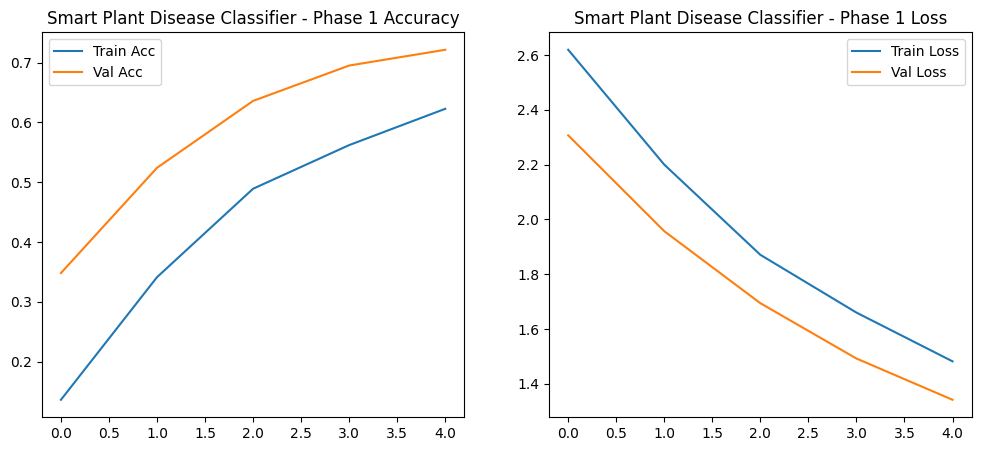

In [9]:
# STEP 6: Training Phase 1 (Feature Extraction)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ckpt = ModelCheckpoint("best_phase1_model.keras", monitor='val_accuracy', save_best_only=True)

history1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[es, ckpt]
)

# Plot Phase 1 Metrics
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.title("Smart Plant Disease Classifier - Phase 1 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title("Smart Plant Disease Classifier - Phase 1 Loss")
plt.legend()
plt.show()


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 147s 585ms/step - accuracy: 0.4311 - loss: 1.9810 - val_accuracy: 0.6752 - val_loss: 1.2808
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 418ms/step - accuracy: 0.6169 - loss: 1.5406 - val_accuracy: 0.7521 - val_loss: 1.0865
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 70s 400ms/step - accuracy: 0.7098 - loss: 1.2160 - val_accuracy: 0.8127 - val_loss: 0.8726
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 412ms/step - accuracy: 0.7691 - loss: 1.0139 - val_accuracy: 0.8469 - val_loss: 0.7036
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 407ms/step - accuracy: 0.8168 - loss: 0.8347 - val_accuracy: 0.8803 - val_loss: 0.5764
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 411ms/step - accuracy: 0.8445 - loss: 0.6967 - val_accuracy: 0.8981 - val_loss: 0.4802
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 405ms/step - accuracy: 0.8616 - loss: 0.5959 - val_accuracy: 0.9081 - val_loss: 0.4118
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 71s 406ms/step - accuracy: 0.8784 - loss: 

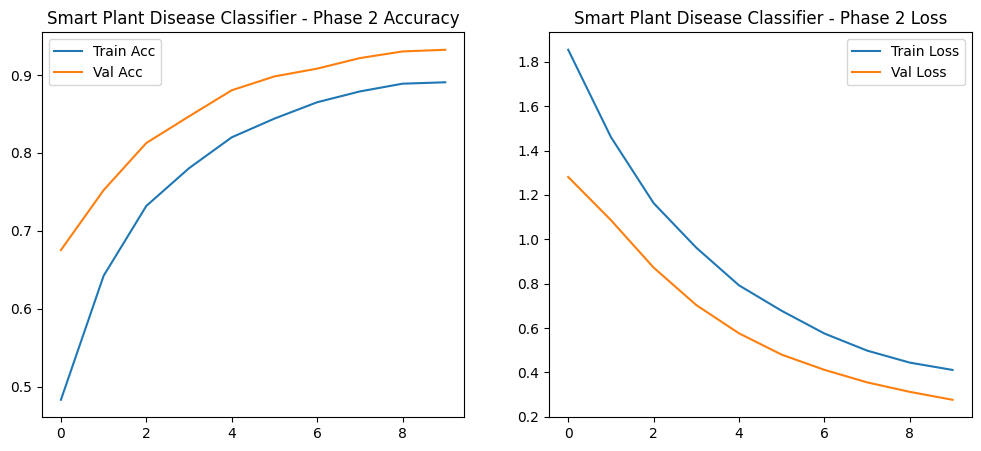

In [10]:
# STEP 7: Training Phase 2 (Fine-Tuning)
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Unfreeze last 80 layers of the base model
for layer in base_model.layers[-80:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
es2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
ckpt2 = ModelCheckpoint("best_phase2_model.keras", monitor='val_accuracy', save_best_only=True)

# Fine-tune the model
history2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[es2, ckpt2]
)

# Plot Phase 2 Metrics
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title("Smart Plant Disease Classifier - Phase 2 Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Smart Plant Disease Classifier - Phase 2 Loss")
plt.legend()

plt.show()

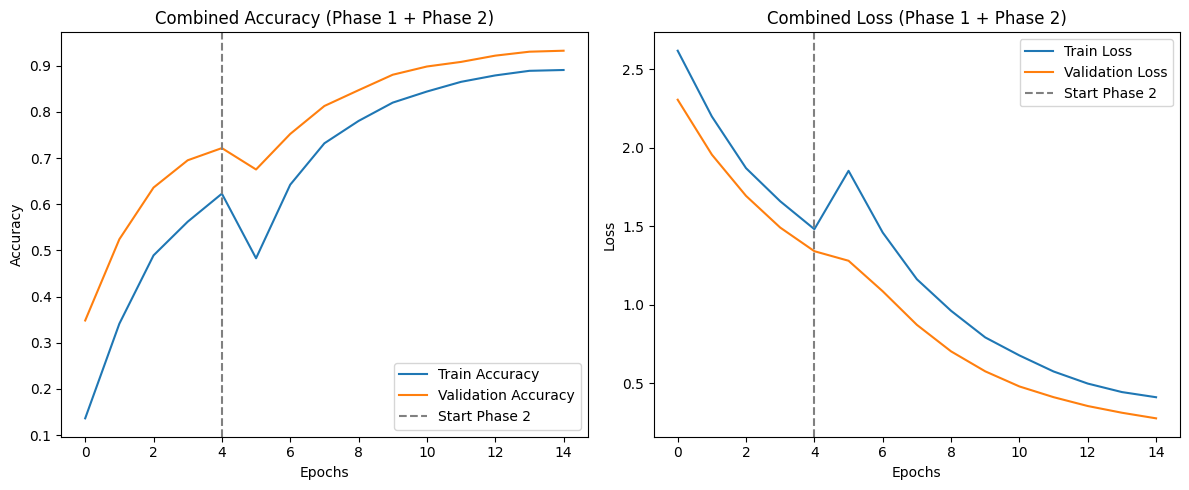

In [11]:
# Combine metrics from Phase 1 and Phase 2
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

# Plot Combined Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=len(history1.history['accuracy']) - 1, color='gray', linestyle='--', label='Start Phase 2')
plt.title("Combined Accuracy (Phase 1 + Phase 2)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=len(history1.history['loss']) - 1, color='gray', linestyle='--', label='Start Phase 2')
plt.title("Combined Loss (Phase 1 + Phase 2)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9358 - loss: 0.2681
Final Validation Accuracy: 0.9323, Loss: 0.2770
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


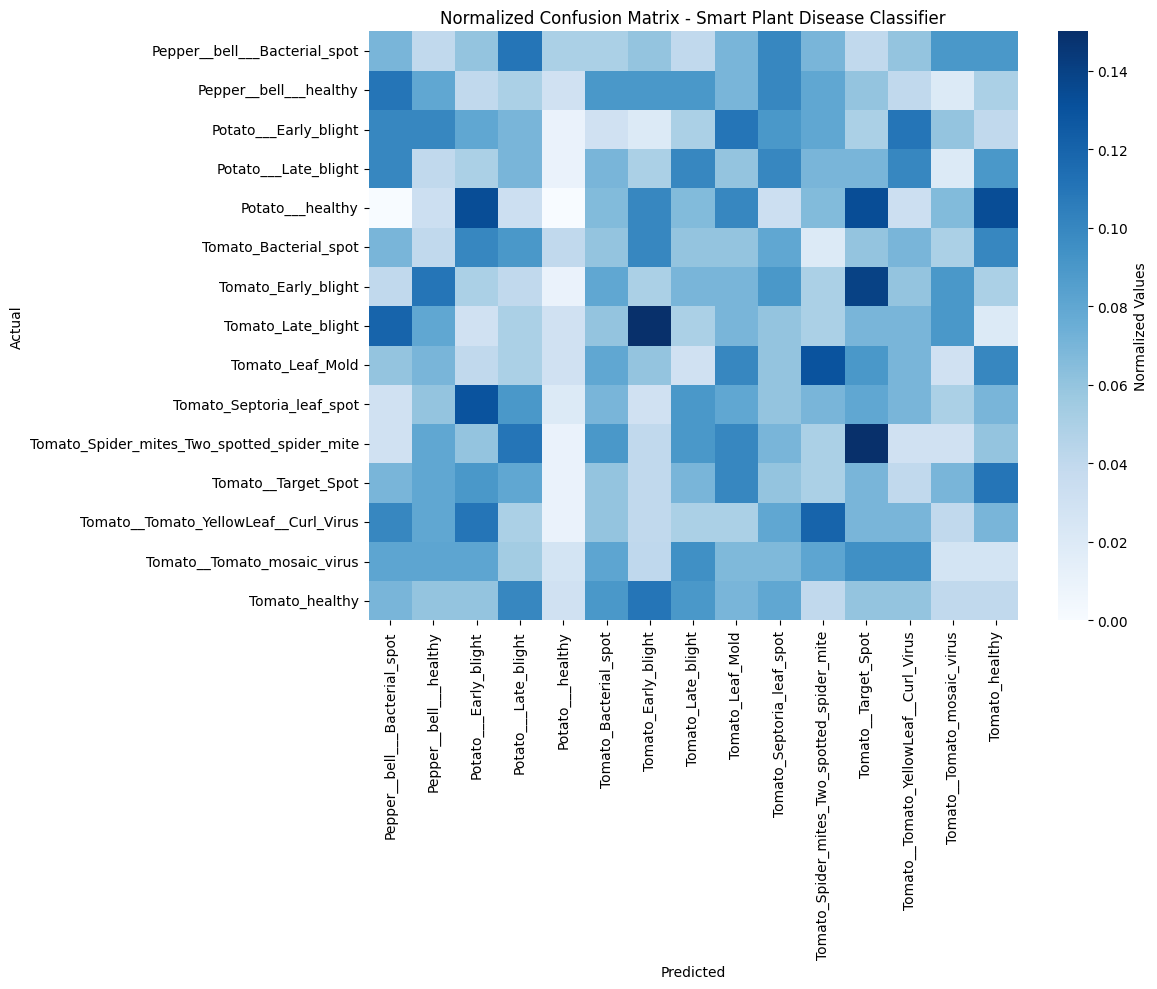

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.07      0.07      0.07       100
                     Pepper__bell___healthy       0.08      0.08      0.08       100
                      Potato___Early_blight       0.08      0.08      0.08       100
                       Potato___Late_blight       0.07      0.07      0.07       100
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.06      0.06      0.06       100
                        Tomato_Early_blight       0.06      0.05      0.05       100
                         Tomato_Late_blight       0.05      0.05      0.05       100
                           Tomato_Leaf_Mold       0.09      0.10      0.10       100
                  Tomato_Septoria_leaf_spot       0.06      0.06      0.06       100
Tomato_Spider_mites_Two_spotted_spider_mi

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 8: Evaluation
val_loss, val_acc = model.evaluate(valid_generator)
print(f"Final Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

# Predictions
y_true = valid_generator.classes
y_pred = np.argmax(model.predict(valid_generator), axis=1)

# Confusion Matrix (Normalized)
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Plotting Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=False,
    cmap='Blues',
    xticklabels=valid_generator.class_indices.keys(),
    yticklabels=valid_generator.class_indices.keys(),
    fmt='.2f',
    cbar_kws={'label': 'Normalized Values'}
)
plt.title("Normalized Confusion Matrix - Smart Plant Disease Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(valid_generator.class_indices.keys())))


In [14]:
# STEP 9: Test Prediction Function
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_disease(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    from tensorflow.keras.applications.efficientnet import preprocess_input
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class = list(train_generator.class_indices.keys())[np.argmax(preds)]
    confidence = np.max(preds)
    return predicted_class, confidence

# Test with one image
sample_image_path = "/content/PlantVillage/Pepper__bell___healthy/00100ffa-095e-4881-aebf-61fe5af7226e___JR_HL 7886.JPG"
pred_class, conf = predict_disease(sample_image_path)
print(f"Predicted Disease: {pred_class} with confidence: {conf:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted Disease: Pepper__bell___healthy with confidence: 0.99


In [15]:
# STEP 10: Save Model
model.save("smart_plant_disease_classifier.keras")
print("Model saved as smart_plant_disease_classifier.keras")

Model saved as smart_plant_disease_classifier.keras


## **Dilhara U.G.T - IT22309624**

### Plant Disease Classification using Deep Learning - ResNet50

#### Initionating the model

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [ ]:
# Fix folder structure if nested

import os
import shutil


# Check if inner folder exists

# Define the expected path to the unzipped dataset
dataset_path = '/content/PlantVillage'

# Check if a common inner folder exists ('PlantVillage')
inner_folder_name = 'PlantVillage'
inner_folder_path = os.path.join(dataset_path, inner_folder_name)

if os.path.exists(inner_folder_path) and os.path.isdir(inner_folder_path):
    print(f"Inner folder '{inner_folder_name}' found at: {inner_folder_path} \n")
    # List contents of the inner folder
    print("Contents of the inner folder: \n")
    for item in os.listdir(inner_folder_path):
        print(item)
else:
    print(f"Inner folder '{inner_folder_name}' not found at: {inner_folder_path}")
    # If the common inner folder is not found, list the contents of the main dataset directory
    print(f"Contents of the main dataset directory ({dataset_path}):")
    for item in os.listdir(dataset_path):
        print(item)


Inner folder 'PlantVillage' found at: /content/PlantVillage/PlantVillage 

Contents of the inner folder: 

Potato___Early_blight
Tomato_Leaf_Mold
Tomato_Early_blight
Pepper__bell___healthy
Tomato__Tomato_mosaic_virus
Potato___healthy
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Septoria_leaf_spot
Pepper__bell___Bacterial_spot
Tomato_Late_blight
Potato___Late_blight
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato__Target_Spot
Tomato_Bacterial_spot


In [ ]:
# Create smaller dataset for fast demo (optional)

original_dir = "/content/PlantVillage/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200  # limit per class for faster runs

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

# Remove empty dirs if any
for class_name in os.listdir(fast_dir):
    class_path = os.path.join(fast_dir, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        os.rmdir(class_path)
        print(f"Removed empty directory: {class_name}")

print("Fast demo dataset created at:", fast_dir)

# Use fast dataset
data_dir = fast_dir

Fast demo dataset created at: /content/PlantVillage_FastDemo


In [ ]:
# Data Preprocessing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 - specific preprocessing
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # ResNet50 default size
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Get class names
class_names = list(train_ds.class_indices.keys())
NUM_CLASSES = len(class_names)
print(f"\nTraining samples: {train_ds.samples}, Validation samples: {val_ds.samples}, Number of classes detected: {NUM_CLASSES}  \n")
print("Classes:", class_names)



Found 2362 images belonging to 15 classes.
Found 590 images belonging to 15 classes.

Training samples: 2362, Validation samples: 590, Number of classes detected: 15  

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


#### Model Development

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

IMG_SIZE = 224
NUM_CLASSES = 15


# Load a pre-trained base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(NUM_CLASSES, activation='softmax')(x)

ResNet50_model = Model(inputs=base_model.input, outputs=output, name="smart_plant_disease_classifier")


print("Model Summary:")
ResNet50_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary:


Model: "smart_plant_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,919 (90.99 MB)

 Trainable params: 264,207 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile
ResNet50_model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train head (Stage 1)
early_stop_stage1 = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train model
history_stage1 = ResNet50_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop_stage1 ],   # reduce_lr_stage1
    verbose=1
)

# Evaluate model
loss, acc = ResNet50_model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
39/74 ━━━━━━━━━━━━━━━━━━━━ 3:35 6s/step - accuracy: 0.2390 - loss: 2.4619

In [ ]:
# Fine-tune top layers (Stage 2)
for layer in base_model.layers[-30:]:
    layer.trainable = True


# Re-compile with lower learning rate for fine-tuning
ResNet50_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR!  0.0001
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Re-enable callbacks (Optional but recommended)
early_stop_stage2 = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)
reduce_lr_stage2 = ReduceLROnPlateau(
    monitor="val_loss",
    patience=2,
    factor=0.5,
    min_lr=1e-7
)

# Fine-tune (train) for a few more epochs
history_stage2 = ResNet50_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # for fine-tuning
    callbacks=[early_stop_stage2, reduce_lr_stage2],
    verbose=1
)


# Evaluate model
loss, acc = ResNet50_model.evaluate(val_ds)
print(f"Validation Accuracy after fine-tune: {acc:.4f}")
print(f"Validation Accuracy after fine-tune: {acc * 100:.2f}%")


Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 2348s 32s/step - accuracy: 0.2685 - loss: 2.2692 - val_accuracy: 0.0576 - val_loss: 2.9538 - learning_rate: 1.0000e-04
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 2296s 31s/step - accuracy: 0.2869 - loss: 2.2082 - val_accuracy: 0.0576 - val_loss: 2.9417 - learning_rate: 1.0000e-04
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 2271s 31s/step - accuracy: 0.2823 - loss: 2.1762 - val_accuracy: 0.1288 - val_loss: 2.7301 - learning_rate: 1.0000e-04
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 2337s 32s/step - accuracy: 0.3158 - loss: 2.1142 - val_accuracy: 0.1644 - val_loss: 2.7914 - learning_rate: 1.0000e-04
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 2250s 30s/step - accuracy: 0.3245 - loss: 2.1055 - val_accuracy: 0.1610 - val_loss: 2.5225 - learning_rate: 1.0000e-04
19/19 ━━━━━━━━━━━━━━━━━━━━ 440s 23s/step - accuracy: 0.1600 - loss: 2.5391
Validation Accuracy after fine-tune: 0.1610
Validation Accuracy after fine-tune: 16.10%


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Path to your test image

img_path = "/content/PlantVillage/PlantVillage/Tomato_Late_blight/005e3b43-9050-47da-9498-f9ecdcc703b3___RS_Late.B 5104.JPG"

# Load & preprocess image

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
pred = ResNet50_model.predict(img_array)
class_index = np.argmax(pred, axis=1)[0]

# Map to class label (use your training dict)
class_labels = {v: k for k, v in train_ds.class_indices.items()}
predicted_label = class_labels[class_index]

print(f"Predicted Disease: {predicted_label}")


In [ ]:
import matplotlib.pyplot as plt

def plot_combined_history(history1, history2, title="ResNet50 Training Performance"):
    # Concatenate metrics
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    #  Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.axvline(x=len(history1.history['accuracy']), color='k', linestyle='--', label='Start Fine-Tuning')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    #  Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.axvline(x=len(history1.history['loss']), color='k', linestyle='--', label='Start Fine-Tuning')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call this function with your ResNet50 histories
plot_combined_history(history_stage1, history_stage2, title="ResNet50: Plant Disease Classification")



In [ ]:
# Save the entire model (architecture + weights + training config)
ResNet50_model.save("smart_plant_disease_classifier_ResNet50_model.keras")
print("Model saved as smart_plant_disease_classifier_ResNet50_model.keras")


Model saved as smart_plant_disease_classifier_vit_finetuned_model.keras


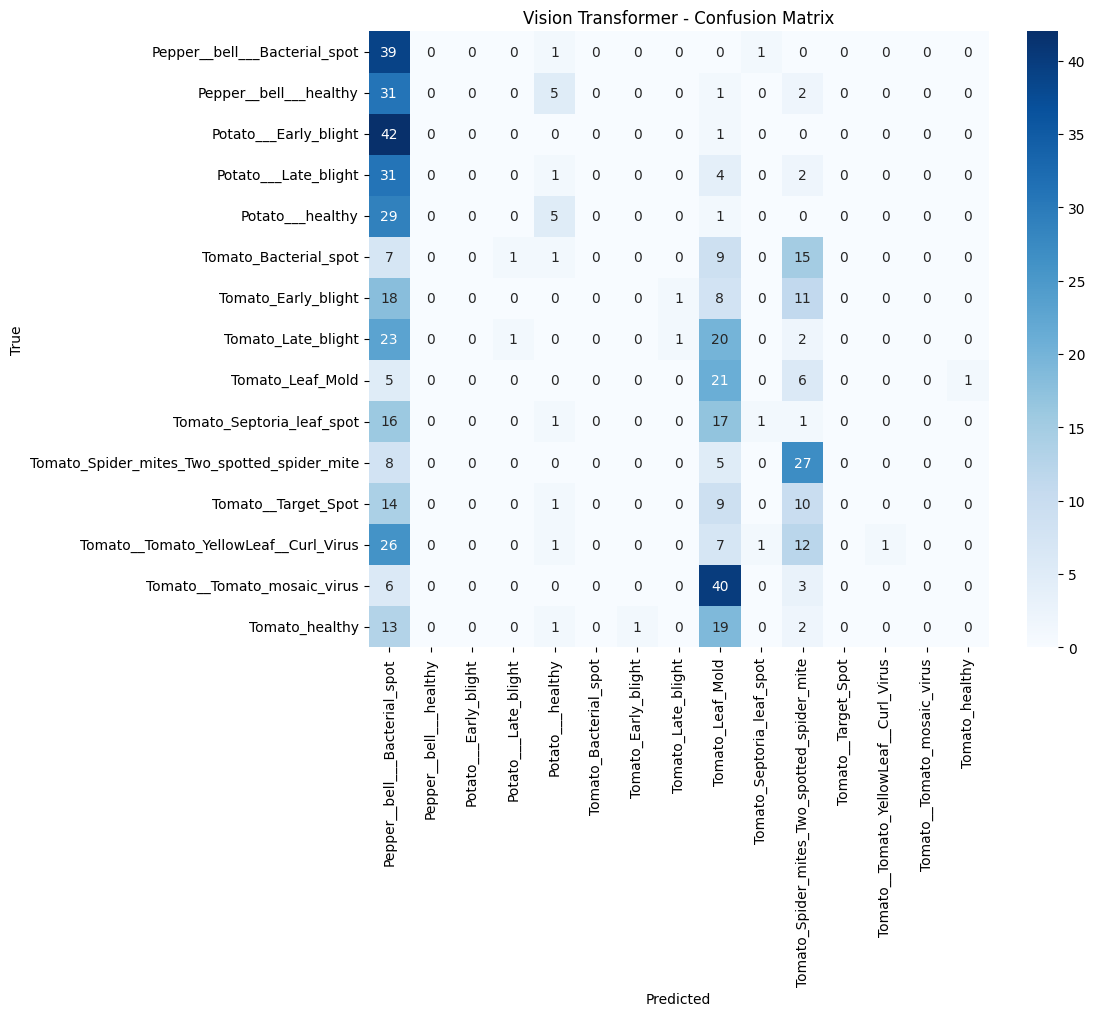

Classification Report for Vision Transformer Model:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.13      0.95      0.22        41
                     Pepper__bell___healthy       0.00      0.00      0.00        39
                      Potato___Early_blight       0.00      0.00      0.00        43
                       Potato___Late_blight       0.00      0.00      0.00        38
                           Potato___healthy       0.29      0.14      0.19        35
                      Tomato_Bacterial_spot       0.00      0.00      0.00        33
                        Tomato_Early_blight       0.00      0.00      0.00        38
                         Tomato_Late_blight       0.50      0.02      0.04        47
                           Tomato_Leaf_Mold       0.13      0.64      0.22        33
                  Tomato_Septoria_leaf_spot       0.33      0.03      0.05        36
Tomato_Spide

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Gather all validation images and labels
X_val = []
y_true = []
for images, labels in val_ds:
    X_val.append(images)
    y_true.extend(np.argmax(labels, axis=1))

X_val = np.concatenate(X_val, axis=0)
y_true = np.array(y_true)

# Predict all at once (MUCH faster)
y_pred_probs = ResNet50_model.predict(X_val, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet50 Model - Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report for ResNet50 Model:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Overall Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Overall Validation Accuracy: {acc:.4f}")
print(f"Overall Validation Accuracy: {acc * 100:.2f}%")

# **PLANT DISEASE DETECTION - MODEL COMPARISON**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checking model files in Google Drive...
 MobileNetV2: Found
 Custom CNN: Found
 EfficientNetB0: Found
 ResNet50: Found
Found 590 images belonging to 15 classes.
Found 590 images belonging to 15 classes.
Found 590 images belonging to 15 classes.
Found 590 images belonging to 15 classes.

Classes (15): ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Validation samples: 590

Loading models from Google Drive...
 MobileNetV2 loaded
 Custom CNN loaded
 EfficientNetB0 loaded
 ResNet50 loaded

Evaluating MobileNet

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating Custom CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating EfficientNetB0...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating ResNet50...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



FINAL MODEL COMPARISON RESULTS
         Model  Accuracy  Model Size (MB)  Parameters (M)  Inference Time (ms)
   MobileNetV2    0.8610          25.2628          2.4240              17.7313
    Custom CNN    0.6339          60.1371          5.2477               4.7151
EfficientNetB0    0.9119          41.1706          4.0688              17.5316
      ResNet50    0.9644         203.9024         23.8519              22.6544

 Results saved to: /content/drive/MyDrive/DL/model_comparison_results.csv


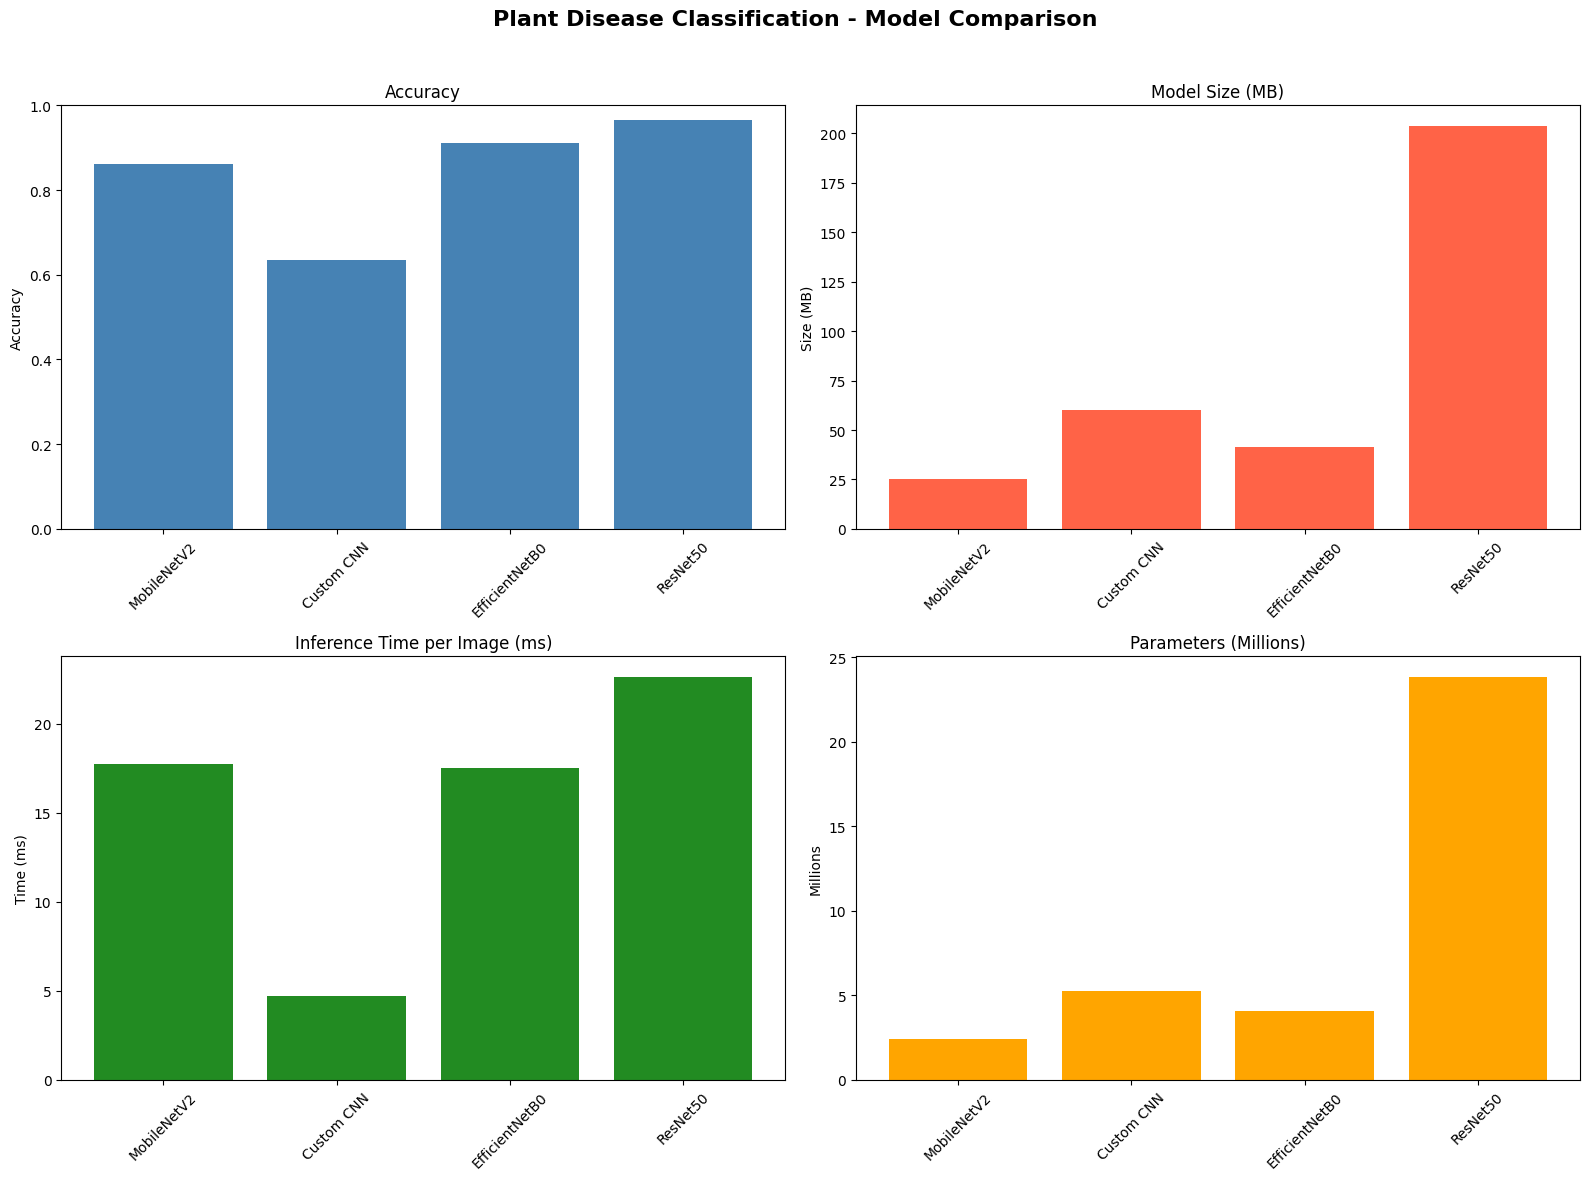

 Plot saved to: /content/drive/MyDrive/DL/model_comparison.png


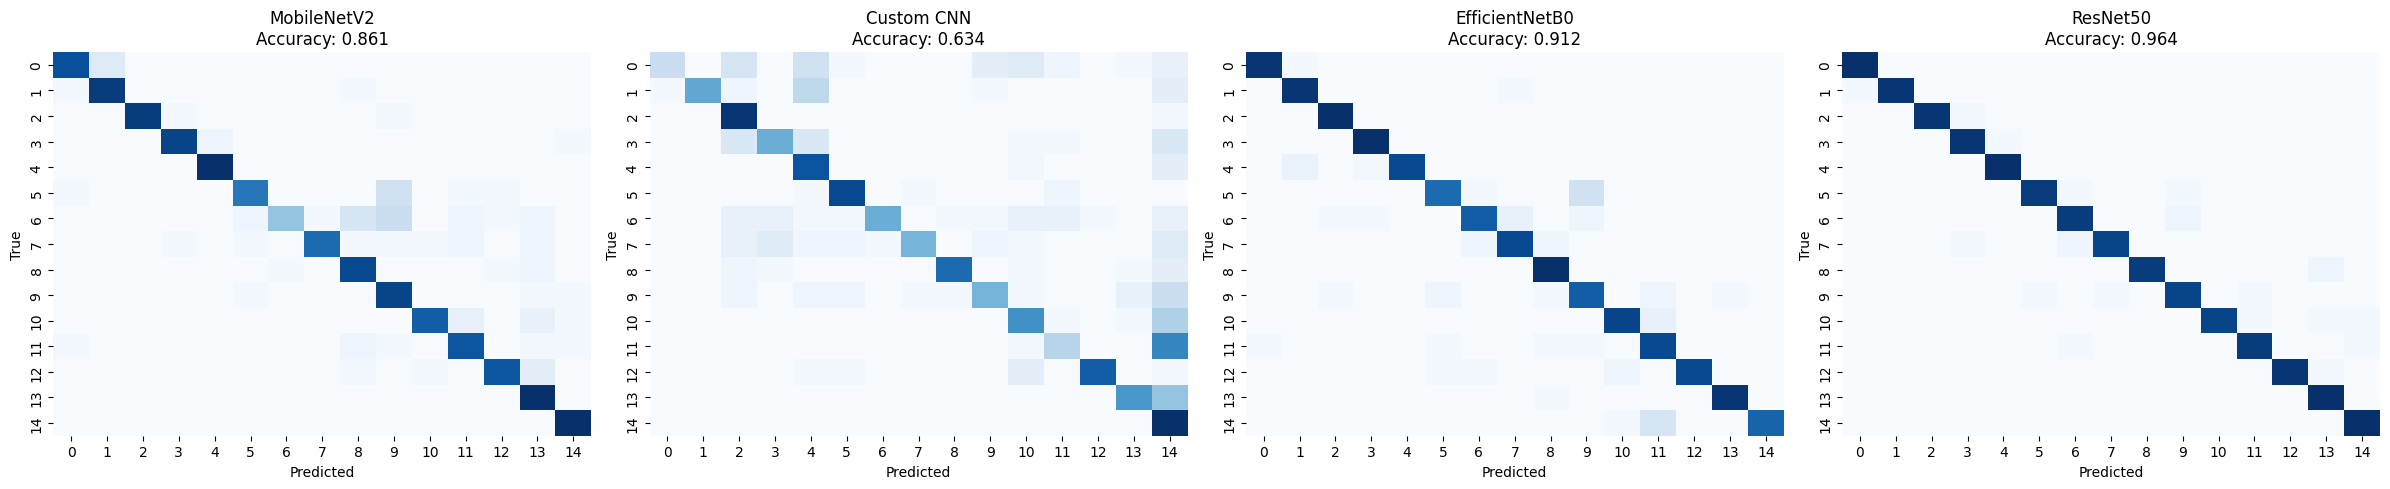

 Confusion matrices saved to: /content/drive/MyDrive/DL/confusion_matrices.png

KEY INSIGHTS
 Highest Accuracy: ResNet50 (0.9644)
 Fastest Inference: Custom CNN (4.72 ms/image)
 Smallest Model: MobileNetV2 (25.26 MB)

 COMPARISON COMPLETE!
All results saved to your Google Drive in /DL folder.


In [ ]:
# PLANT DISEASE DETECTION - MODEL COMPARISON

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
plt.style.use('default')
sns.set_palette("husl")

# 2. Verify model files exist in Drive
model_paths = {
    'MobileNetV2': '/content/drive/MyDrive/DL/mobilenetv2_plant_disease_model.keras',
    'Custom CNN': '/content/drive/MyDrive/DL/custom_cnn_plant_disease.keras',
    'EfficientNetB0': '/content/drive/MyDrive/DL/smart_plant_disease_classifier.keras',
    'ResNet50': '/content/drive/MyDrive/DL/smart_plant_disease_classifier_ResNet50_model.keras'
}

print("Checking model files in Google Drive...")
for name, path in model_paths.items():
    if os.path.exists(path):
        print(f" {name}: Found")
    else:
        print(f" {name}: NOT FOUND at {path}")
        print("Please ensure models are saved to /MyDrive/DL/ folder.")
        raise FileNotFoundError(f"Missing required model: {name}")


# 3. Prepare dataset (same as used during training)
FAST_DIR = "/content/PlantVillage_FastDemo"

# If dataset not present, recreate it quickly
if not os.path.exists(FAST_DIR):
    print("Recreating fast demo dataset...")
    import shutil
    !unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

    inner_dir = "/content/PlantVillage/PlantVillage"
    if os.path.exists(inner_dir):
        for folder in os.listdir(inner_dir):
            src = os.path.join(inner_dir, folder)
            dst = os.path.join("/content/PlantVillage", folder)
            shutil.move(src, dst)
        os.rmdir(inner_dir)

    # Create fast demo (200 per class)
    original_dir = "/content/PlantVillage"
    images_per_class = 200
    os.makedirs(FAST_DIR, exist_ok=True)

    for class_name in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_name)
        if os.path.isdir(class_path):
            fast_class_path = os.path.join(FAST_DIR, class_name)
            os.makedirs(fast_class_path, exist_ok=True)
            img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            for img in img_files[:images_per_class]:
                shutil.copy(os.path.join(class_path, img), os.path.join(fast_class_path, img))

# Remove empty dirs
for class_name in os.listdir(FAST_DIR):
    class_path = os.path.join(FAST_DIR, class_name)
    if os.path.isdir(class_path) and len(os.listdir(class_path)) == 0:
        os.rmdir(class_path)

# 4. Create validation generators (MUST match training setup)
BATCH_SIZE = 32

# For MobileNetV2 (224x224 + mobilenet preprocess)
mobilenet_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    validation_split=0.2
)
val_mobilenet = mobilenet_datagen.flow_from_directory(
    FAST_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# For EfficientNetB0 (224x224 + efficientnet preprocess)
efficientnet_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    validation_split=0.2
)
val_efficientnet = efficientnet_datagen.flow_from_directory(
    FAST_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# For Custom CNN (128x128 + /255 normalization)
cnn_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
val_cnn = cnn_datagen.flow_from_directory(
    FAST_DIR,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# For ResNet50 (224x224 + resnet preprocess)
resnet_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    validation_split=0.2
)
val_resnet = resnet_datagen.flow_from_directory(
    FAST_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(val_mobilenet.class_indices.keys())
print(f"\nClasses ({len(class_names)}): {class_names}")
print(f"Validation samples: {val_mobilenet.samples}")

# 5. Load models from Google Drive
print("\nLoading models from Google Drive...")
models = {}
models['MobileNetV2'] = load_model(model_paths['MobileNetV2'])
print(" MobileNetV2 loaded")
models['Custom CNN'] = load_model(model_paths['Custom CNN'])
print(" Custom CNN loaded")
models['EfficientNetB0'] = load_model(model_paths['EfficientNetB0'])
print(" EfficientNetB0 loaded")
models['ResNet50'] = load_model(model_paths['ResNet50'])
print(" ResNet50 loaded")


# 6. Evaluation function
import time

def evaluate_model(model, val_gen, model_name):
    print(f"\nEvaluating {model_name}...")

    # Get true labels
    y_true = val_gen.classes  # categorical gives integer classes

    # Predictions
    start_time = time.time()
    y_pred_proba = model.predict(val_gen, verbose=0)
    total_time = time.time() - start_time

    y_pred = np.argmax(y_pred_proba, axis=1)

    # Handle potential class mismatch (ViT was trained with 15 classes, but we have 16)
    if len(y_true) != len(y_pred):
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
        print(f"  Truncated to {min_len} samples due to length mismatch")

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    inference_time_per_image = (total_time / len(y_true)) * 1000  # ms

    # Model size
    model_size_mb = os.path.getsize(model_paths[model_name]) / (1024 * 1024)
    params = model.count_params()

    return {
        'accuracy': accuracy,
        'inference_time_ms': inference_time_per_image,
        'model_size_mb': model_size_mb,
        'parameters_millions': params / 1e6,
        'y_true': y_true,
        'y_pred': y_pred
    }

# 7. Evaluate all models
results = {}
results['MobileNetV2'] = evaluate_model(models['MobileNetV2'], val_mobilenet, 'MobileNetV2')
results['Custom CNN'] = evaluate_model(models['Custom CNN'], val_cnn, 'Custom CNN')
results['EfficientNetB0'] = evaluate_model(models['EfficientNetB0'], val_efficientnet, 'EfficientNetB0')
results['ResNet50'] = evaluate_model(models['ResNet50'], val_resnet, 'ResNet50')


# 8. Create comparison table
comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Model Size (MB)': metrics['model_size_mb'],
        'Parameters (M)': metrics['parameters_millions'],
        'Inference Time (ms)': metrics['inference_time_ms']
    })


df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("FINAL MODEL COMPARISON RESULTS")
print("="*80)
print(df_comparison.round(4).to_string(index=False))

# 9. Save results to Google Drive
output_path = "/content/drive/MyDrive/DL/model_comparison_results.csv"
df_comparison.to_csv(output_path, index=False)
print(f"\n Results saved to: {output_path}")

# 10. Visualization
n_models = len(results)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Plant Disease Classification - Model Comparison', fontsize=16, fontweight='bold')

# Accuracy comparison
axes[0,0].bar(df_comparison['Model'], df_comparison['Accuracy'], color='steelblue')
axes[0,0].set_title('Accuracy')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0, 1)
axes[0,0].tick_params(axis='x', rotation=45)

# Model size
axes[0,1].bar(df_comparison['Model'], df_comparison['Model Size (MB)'], color='tomato')
axes[0,1].set_title('Model Size (MB)')
axes[0,1].set_ylabel('Size (MB)')
axes[0,1].tick_params(axis='x', rotation=45)

# Inference time
axes[1,0].bar(df_comparison['Model'], df_comparison['Inference Time (ms)'], color='forestgreen')
axes[1,0].set_title('Inference Time per Image (ms)')
axes[1,0].set_ylabel('Time (ms)')
axes[1,0].tick_params(axis='x', rotation=45)

# Parameters
axes[1,1].bar(df_comparison['Model'], df_comparison['Parameters (M)'], color='orange')
axes[1,1].set_title('Parameters (Millions)')
axes[1,1].set_ylabel('Millions')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plot_path = "/content/drive/MyDrive/DL/model_comparison.png"
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f" Plot saved to: {plot_path}")

# 11. Confusion Matrices
n_models = len(results)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
if n_models == 1:
    axes = [axes]

for idx, (model_name, res) in enumerate(results.items()):
    cm = confusion_matrix(res['y_true'], res['y_pred'], normalize='true')
    sns.heatmap(cm, ax=axes[idx], cmap='Blues', cbar=False)
    axes[idx].set_title(f'{model_name}\nAccuracy: {res["accuracy"]:.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.tight_layout()
cm_path = "/content/drive/MyDrive/DL/confusion_matrices.png"
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f" Confusion matrices saved to: {cm_path}")

# 12. Final Summary
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

best_acc = df_comparison.loc[df_comparison['Accuracy'].idxmax()]
best_speed = df_comparison.loc[df_comparison['Inference Time (ms)'].idxmin()]
smallest_model = df_comparison.loc[df_comparison['Model Size (MB)'].idxmin()]

print(f" Highest Accuracy: {best_acc['Model']} ({best_acc['Accuracy']:.4f})")
print(f" Fastest Inference: {best_speed['Model']} ({best_speed['Inference Time (ms)']:.2f} ms/image)")
print(f" Smallest Model: {smallest_model['Model']} ({smallest_model['Model Size (MB)']:.2f} MB)")

print("\n COMPARISON COMPLETE!")
print("All results saved to your Google Drive in /DL folder.")